# Movie Recomender

In this notebook we are going to explore several ways of recommending movies. The first Method is using "collabrative filtering." In it's essence we are grouping movies as similar by how similarly people have rated them. For instance if "User A" and "User B" rated "Movie X"  5/5 and 2/5 respectivly and rated "Movie Y"  4/5 and 1/5 respectivly then "Movie X" and "Movie Y" are considered similar and either one will be a recomendation for the other.

## Cleaning the Data

The data comes in the form of three tables: 
* Ratings: Has the users and how they rated various movies
* Movies_Metadata: Has all data concerning the movie such as release date and genre
* Credits: Has the people involved in the movie

In [34]:
import pandas as pd
import scipy.sparse as sparse

import numpy as np
from numpy.linalg import solve

from sklearn.decomposition import NMF
from scipy.sparse.linalg import spsolve, svds

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [35]:
ratings_df = pd.read_csv('Data/ratings_small.csv')

In [36]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [37]:
movies_df = pd.read_csv('Data/movies_metadata.csv')

In [38]:
movies_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [39]:
#Dropping columns that are not related to the rating and wont serve as filters 
movies_df.drop(columns=[
            'belongs_to_collection',
            'homepage','imdb_id', 
            'original_title', 
            'overview', 
            'spoken_languages', 
            'status', 'tagline', 
            'poster_path',
            'video'
        ], inplace = True)

In [40]:
'''
The table contains columns that have information as JSON objects however appear as strings. 
To be able to use them as JSON objects we use literal_eval which will take the string and interret as a JSON object
In the below code we are taking the primary production company and country
'''
from ast import literal_eval

production_countries = []
production_companies = []
for index, row in movies_df.iterrows():
    # we are using a try and except statment as some of the information is missing and when we hit a keyerror we would like 
    # the column to reflect the missing information with a Null
    try:
        production_countries.append(literal_eval(movies_df['production_countries'][index])[0]['name'])
    except:
        production_countries.append(None)
    try:
        production_companies.append(literal_eval(movies_df['production_companies'][index])[0]['name'])
    except:
        production_companies.append(None) 
movies_df['production_countries'] = production_countries
movies_df['production_companies'] = production_companies
movies_df.head()

,adult,budget,genres,id,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,21.9469,Pixar Animation Studios,United States of America,1995-10-30,373554033.0,81.0,Toy Story,7.7,5415.0
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,17.0155,TriStar Pictures,United States of America,1995-12-15,262797249.0,104.0,Jumanji,6.9,2413.0
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,11.7129,Warner Bros.,United States of America,1995-12-22,0.0,101.0,Grumpier Old Men,6.5,92.0
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,3.85949,Twentieth Century Fox Film Corporation,United States of America,1995-12-22,81452156.0,127.0,Waiting to Exhale,6.1,34.0
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,8.38752,Sandollar Productions,United States of America,1995-02-10,76578911.0,106.0,Father of the Bride Part II,5.7,173.0


In [41]:
# we want users to be able to filter by year as there is a correlation between movies made in the same period. 
# Hoever specific date does not matter and therefore we are simplifying th column
movies_df['release_date'] = [str(release_date).split('-')[0] for release_date in movies_df['release_date']]

In [42]:
# the genres come with IDs which are more or less meaningless for our purpose and therefore cleaning up the column so it is a list of genres
movie_genres = []
for genres in movies_df['genres']:
    movie_genres.append([genre['name'] for genre in literal_eval(genres)])
movies_df['genres'] = movie_genres

In [43]:
credits_df = pd.read_csv('Data/credit.csv')
credits_df.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [44]:
# to simplify the filtering we are having it so users will only be filtering by the main actor or their gender
main_actor = []
main_actor_gender = []

for cast in credits_df['cast']:
    try:
        main_actor.append(literal_eval(cast)[0]['name'])
        main_actor_gender.append(literal_eval(cast)[0]['gender'])
    except:
        main_actor.append(None)
        main_actor_gender.append(None)
credits_df['main_actor'] = main_actor
credits_df['main_actor_gender'] = main_actor_gender

In [45]:
# to simplify the filtering we are having it so users will only be filtering by the directo or their gender
# in the list of cast the director tends to be the first crew member
director = []
director_gender = []

for crew in credits_df['crew']:
    try:
        director.append(literal_eval(crew)[0]['name'])
        director_gender.append(literal_eval(crew)[0]['gender'])
    except:
        director.append(None)
        director_gender.append(None)
credits_df['director'] = director
credits_df['director_gender'] = director_gender

In [46]:
movies_df.head()

,adult,budget,genres,id,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count
0,False,30000000,"[Animation, Comedy, Family]",862,en,21.9469,Pixar Animation Studios,United States of America,1995,373554033.0,81.0,Toy Story,7.7,5415.0
1,False,65000000,"[Adventure, Fantasy, Family]",8844,en,17.0155,TriStar Pictures,United States of America,1995,262797249.0,104.0,Jumanji,6.9,2413.0
2,False,0,"[Romance, Comedy]",15602,en,11.7129,Warner Bros.,United States of America,1995,0.0,101.0,Grumpier Old Men,6.5,92.0
3,False,16000000,"[Comedy, Drama, Romance]",31357,en,3.85949,Twentieth Century Fox Film Corporation,United States of America,1995,81452156.0,127.0,Waiting to Exhale,6.1,34.0
4,False,0,[Comedy],11862,en,8.38752,Sandollar Productions,United States of America,1995,76578911.0,106.0,Father of the Bride Part II,5.7,173.0


In [47]:
credits_df.drop(columns=['cast', 'crew'], inplace = True)

In [48]:
credits_df.head()

,id,main_actor,main_actor_gender,director,director_gender
0,862,Tom Hanks,2.0,John Lasseter,2.0
1,8844,Robin Williams,2.0,Larry J. Franco,2.0
2,15602,Walter Matthau,2.0,Howard Deutch,2.0
3,31357,Whitney Houston,1.0,Forest Whitaker,2.0
4,11862,Steve Martin,2.0,Alan Silvestri,2.0


In [49]:
ratings_df.drop(columns=['timestamp'], inplace = True) # remove timestamp of when the rating happened

In [50]:
ratings_df.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


## Merging the tables

all three tables have MovieID as a common key, this appears as MovieID in rating table and ID in the movie_metadata and credits table
we join the movie_metadata table to the rating table. The movie ID which is unique in the other two tables appears multiple times in the rating table
this is obviously due to multiple users who rate a given movie. Therefore to not lose any information during the Join we join everythin to Ratings

In [51]:
# we found that the column was not being read as int64 and some of the numbers in the 4000 range were being interpreted as date
# the movies with oddly formated IDs will be dropped during the join
movies_df['id'] = pd.to_numeric(movies_df['id'], errors='coerce').fillna(0)
movies_df["id"] = movies_df["id"].astype('int64')

In [52]:
#ratings_df = ratings_df['movieId'].apply(lambda x: x in movies_df['id'].tolist())
ratings_df = ratings_df[ratings_df['movieId'].apply(lambda x: x in movies_df['id'].tolist())]

In [53]:
df_combined = pd.merge(ratings_df, movies_df, left_on='movieId', right_on='id', how='left')

In [54]:
df_combined.drop(columns=['id'], inplace = True) # drop the extra ID column after joining Movie_metadata to ratings

In [55]:
df_combined = pd.merge(df_combined, credits_df, left_on='movieId', right_on='id', how='left') #join credit tableto combines rating and metadeta table

In [56]:
df_combined.drop(columns=['id'], inplace = True) # drop extra ID column after join

In [57]:
df_combined.dropna(inplace = True) #to prevent any errors from user filters we drop NAs

We want to get rid of obscure movies in our database as we feel that this will make the recomendations better

In [58]:
df_combined  = df_combined[df_combined['vote_count'] > 100] 
df_combined.head()

,userId,movieId,rating,adult,budget,genres,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count,main_actor,main_actor_gender,director,director_gender
0,1,1371,2.5,False,17000000,[Drama],en,11.6734,United Artists,United States of America,1982,270000000.0,99.0,Rocky III,6.6,894.0,Sylvester Stallone,2.0,Sylvester Stallone,2.0
2,1,2105,4.0,False,11000000,"[Comedy, Romance]",en,18.3442,Universal Pictures,United States of America,1999,235483004.0,95.0,American Pie,6.4,2358.0,Jason Biggs,2.0,Chris Bender,2.0
4,1,2294,2.0,False,22000000,[Comedy],en,11.6194,Dimension Films,United States of America,2001,33788161.0,104.0,Jay and Silent Bob Strike Back,6.4,491.0,Kevin Smith,2.0,Bob Weinstein,2.0
7,2,62,3.0,False,10500000,"[Science Fiction, Mystery, Adventure]",en,22.4946,Stanley Kubrick Productions,United States of America,1968,68700000.0,149.0,2001: A Space Odyssey,7.9,3075.0,Keir Dullea,2.0,Stanley Kubrick,2.0
8,2,110,4.0,False,0,"[Drama, Mystery, Romance]",fr,7.83276,Zespół Filmowy TOR,France,1994,0.0,99.0,Three Colors: Red,7.8,246.0,Irène Jacob,1.0,Krzysztof Kieślowski,2.0


## Making the rating matrix

This matrix will have the user ID as the index and the various movies as columns and the ratings as the values. We take advantage of the pivot_table method from panadas to do this in one step.

In [59]:
movie_rating_matrix = pd.pivot_table(df_combined, values='rating', index='userId',
                                    columns=['title'], aggfunc=np.sum)
movie_rating_matrix.head()

title,10 Things I Hate About You,"10,000 BC",12 Angry Men,1408,15 Minutes,16 Blocks,2 Days in Paris,"20,000 Leagues Under the Sea",2001: A Space Odyssey,2010,...,You Only Live Twice,"You, Me and Dupree",Young Frankenstein,Zardoz,Zatoichi,Zodiac,Zombie Flesh Eaters,eXistenZ,xXx,¡Three Amigos!
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## The Recommender function

The recommender function is taking a movie inputted by the user and seeing which movie had similar ratings per user to determine correlation.

As an example let's take the movie Cast Away and say User 1 gave it a 5 and User 2 gave it a 1. Cast Away would be highly correlated with 2001 Space Odessy which had User 1 rate it as 5 and User 2 rate it as 2. Cast Away would be poorly correlated with Transformers which had User 1 rate it as 2 and USer 2 rate it as 5.

After gathering a list of similarly rated movies we then join that list with our merged dataframe. At this point we no longer care about individuals ratings since we have the correlations so to prevent duplicates in our recommendations we remove duplicates keeping the first instance of the movie.

We can then apply any additional filtering that the recommnder user might like to add.

In [60]:
df_combined.set_index('title', inplace = True) # this will help use when joining the recommendationts which will have title as index.

In [61]:
def movieRecomender(movie_title, **kwargs):
    '''
    Takes a movie and filters and returns up to 5 recommendations.
    
    Parameters
    ----------
    
    movie_title: str
                 representing movie title.
    
    Keyword Arguments
    ----------
    
    adult: Str 'False' or 'True'
    
    original_language: str
                    2 character code
    
    production_companies: str
    
    production_countries: str
    
    main_actor: str
    
    main_actor_gender: int 
                    1 for female and 2 for male
    director: str
    
    director_gender: int
                    1 for female and 2 for male
    
    date_range: tuple
                (start year, end year)
    
    Returns
    ----------
    
    List of up to 5 movie recommendations
    '''
    if not movie_title in df_combined.index: # return error if movie is not in database
        return "Movie not in database"
    movie_corr = pd.DataFrame(movie_rating_matrix.corrwith(movie_rating_matrix[movie_title]), columns=['Correlation'])
    movie_corr = movie_corr.join(df_combined).sort_values(by='Correlation', ascending=False)
    movie_corr = movie_corr[~movie_corr.index.duplicated(keep='first')]
    movie_corr = movie_corr[movie_corr.index != movie_title]
    for key, value in kwargs.items():
        if key == 'genre': # Since the genres are in a list the filtering is different from other keywords
            movie_corr = movie_corr[movie_corr['genres'].apply(lambda x: value in x)]
        elif key == 'date_range':
            if not type(value) is tuple: # To ensure that the date range is given in tuple
                return "You need to pass in a tuple for range argument"
            movie_corr = movie_corr[movie_corr['release_date'].apply(lambda x: value[0] <= int(x) <= value[1])]
        else:
            try:
                movie_corr = movie_corr[movie_corr[key] == value]
            except KeyError:
                return "This is not a possible filter"
    recommendations =  movie_corr.head()
    return recommendations.index.values.tolist()

## Example output

In [62]:
movieRecomender('The Dark Knight',production_companies = 'Columbia Pictures')

['We Own the Night',
 'Big Fish',
 'Fools Rush In',
 'Gandhi',
 'The Thirteenth Floor']

In [63]:
movieRecomender('The Dark Knight',date_range = (1990, 2001))

['Casino',
 'Disclosure',
 'Cutthroat Island',
 'Sneakers',
 'Under Siege 2: Dark Territory']

In [64]:
movieRecomender('The Dark Knight',adult = 'False')

['Short Circuit',
 'Casino',
 'Casablanca',
 'Romeo and Juliet',
 'The Bourne Supremacy']

In [65]:
movieRecomender('The Dark Knight',production_companies = 'Columbia Pictures',date_range = (1990, 2001),adult = 'False')

['Fools Rush In',
 'The Thirteenth Floor',
 'Almost Famous',
 'A River Runs Through It',
 'The Fifth Element']

## Testing the errors

1. Inputting non existent movie

In [66]:
movieRecomender('BootCamp Horrors')

'Movie not in database'

2. Not using a Tuple

In [67]:
movieRecomender('The Dark Knight',date_range = 1990)

'You need to pass in a tuple for range argument'

3. Non-existent keyword argument

In [68]:
movieRecomender('The Dark Knight',is_this_good = True)

'This is not a possible filter'

# SVD: Singular Vector Decomposition

In [69]:
svd_movies_df = movies_df[['id', 'title']]

#svd_movies_df['id'] = pd.to_numeric(svd_movies_df['id'], errors='coerce').fillna(0)
#svd_movies_df["id"] = svd_movies_df["id"].astype('int32')
#svd_movies_df["title"] = svd_movies_df["title"].astype('str')

svd_movies_df.dtypes

id        int64
title    object
dtype: object

In [70]:
svd_rating_df = ratings_df[['userId', 'movieId','rating']]

#svd_rating_df["userId"] = svd_rating_df["userId"].astype('int32')
#svd_rating_df["movieId"] = svd_rating_df["movieId"].astype('int32')
#svd_rating_df["rating"] = svd_rating_df["rating"].astype('float32')

svd_rating_df.dtypes

userId       int64
movieId      int64
rating     float64
dtype: object

In [71]:
movie_features_df = svd_rating_df.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

In [72]:
R = movie_features_df.values

user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [73]:
U, sigma, Vt = svds(R_demeaned)

In [74]:
# that the Sigma$ returned is just the values instead of a diagonal matrix. 
# This is useful, but since I'm going to leverage matrix multiplication to get predictions 
# I'll convert it to the diagonal matrix form.

sigma = np.diag(sigma)

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

preds_df = pd.DataFrame(all_user_predicted_ratings, columns = movie_features_df.columns)
preds_df.head()

movieId,2,3,5,6,11,12,13,14,15,16,...,134158,134368,134569,134881,135536,140174,142507,148652,158238,160718
0,0.021441,0.029617,0.005206,0.016156,-0.015222,0.016488,0.018569,-0.015364,0.008862,0.006058,...,0.001344,-0.004555,-0.000937,-0.006428,0.002941,-0.009979,0.000159,-0.000304,0.004819,-0.010687
1,1.423793,0.519955,0.612923,1.084270,1.477185,0.082897,0.078064,0.403962,0.107801,0.468147,...,-0.007986,-0.005538,-0.001653,0.004456,-0.016981,-0.007012,-0.005806,-0.002820,-0.036909,0.028444
2,0.378671,0.052943,-0.021763,0.554796,0.085465,0.024406,-0.054237,0.026738,0.002822,0.416432,...,-0.007157,0.007634,-0.001593,-0.012617,-0.007341,0.014673,-0.001244,-0.004649,0.010878,-0.012128
3,1.179111,0.739610,0.425496,0.621315,0.830565,0.327062,0.377061,-0.050242,0.164470,0.295105,...,-0.025639,-0.098999,-0.069216,-0.116564,0.002428,-0.219365,-0.054027,-0.046810,-0.002049,-0.191409
4,0.919898,0.171162,0.713657,0.045961,1.029284,0.000989,0.052326,0.093852,0.035428,0.529642,...,-0.036480,0.044786,-0.041115,0.056475,-0.029308,0.058287,-0.037782,-0.029036,-0.025906,0.037349


In [75]:
def recommend_movies(preds_df, userID, movies_df, original_ratings_df, num_recommendations=5):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1
#     print(preds_df.iloc[user_row_number])
#     print(sorted_user_predictions)
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.userId == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'id').
                     sort_values(['rating'], ascending=False)
                 )
#     print(user_full)
#     print 'User {0} has already rated {1} movies.'.format(userID, user_full.shape[0])
#     print 'Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations)
    #                left_on = 'movieId',
#                right_on = 'movieId').
# merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left').rename(columns = {user_row_number: 'Predictions'}).
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['id'].isin(user_full['movieId'])]).merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left', left_on = 'id',
               right_on = 'movieId').rename(columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :-1]
                      

    return user_full, recommendations

In [76]:
already_rated, predictions = recommend_movies(preds_df, 330, svd_movies_df, svd_rating_df, 5)

In [77]:
already_rated.head()

,userId,movieId,rating,id,title
30,330,527,5.0,527,Once Were Warriors
47,330,1683,5.0,1683,The Reaping
18,330,301,5.0,301,Rio Bravo
38,330,1249,5.0,1249,Hollywoodland
16,330,293,5.0,293,A River Runs Through It


In [78]:
predictions

,id,title,movieId
6359,296,Terminator 3: Rise of the Machines,296.0
5826,590,The Hours,590.0
1842,380,Rain Man,380.0
5298,608,Men in Black II,608.0
1290,377,A Nightmare on Elm Street,377.0


## The next section contains an ALS based approach to predict preferences by userid. 

#### Fundamental algorithm is NMF. Non-Negative Matrix Factorization (NMF). Find two non-negative matrices (W, H) whose product approximates the non- negative matrix X. This factorization can be used for example for dimensionality reduction, source separation or topic extraction. Recommender based on KAGGLE movie recommender https://www.kaggle.com/subhamoybhaduri/diff-approaches-of-building-recommender-system

In [80]:
# Import unique ratings and mapping of Movie ID to Title
ratings = pd.read_excel('Data/rating_matrix_moviename.xlsx', sheet_name='rating_matrix_moviename',index_col=0)
title_id= pd.read_excel('Data/rating_matrix_moviename.xlsx', sheet_name='table',header=0, usecols='A:B')

# Convert to numpy array to facilitate matrix operations
data_matrix = np.array(ratings)
nb_users  = data_matrix.shape[0]
nb_movies = data_matrix.shape[1]

# Print shape and data matrix
print(data_matrix.shape)
print(data_matrix)

(671, 2410)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### Generate dataframe of top (5) rated movies by user id

In [81]:
nlargest = 5
order = np.argsort(-ratings.values, axis=1)[:, :nlargest]
result = pd.DataFrame(ratings.columns[order], 
                      columns=['Rating#{}'.format(i) for i in range(1, nlargest+1)],
                      index=ratings.index)

result_top = result.replace(dict(zip(title_id.id,title_id.Title)))
result_top.head(10)

,Rating#1,Rating#2,Rating#3,Rating#4,Rating#5
User_ID,,,,,
1,American Pie,Confidentially Yours,Rocky III,My Tutor,Jay and Silent Bob Strike Back
2,Berlin: Symphony of a Great City,"Monsters, Inc.",The Poseidon Adventure,The Hours,The Conversation
3,The Million Dollar Hotel,License to Wed,Terminator 3: Rise of the Machines,All the Way Boys,The Ewok Adventure
4,Arlington Road,The 39 Steps,Rush Hour,Final Fantasy: The Spirits Within,Light of Day
5,Gleaming the Cube,Titanic,Downhill Racer,Get Carter,Underworld
6,A River Runs Through It,Secret Agent,Ghost Rider,Torrente 3 The Protector,My Best Friend's Wedding
7,The Sixth Sense,The 39 Steps,Three Colors: Red,The Million Dollar Hotel,Greed
8,Blackmail,The Tunnel,Once Were Warriors,Fahrenheit 9/11,My Name Is Bruce
9,Once Were Warriors,The Hidden Fortress,Men in Black II,Terminator Salvation,Mothra vs. Godzilla


#### Apply NMF based ALS techniques to predict ratings for movies that have not been rated. Preferences generated by user id

In [82]:
# NMF factorization into user vector and item vector
model = NMF(n_components=2, init='random', random_state=42)
user_vec = model.fit_transform(data_matrix)
item_vec = model.components_.T

def implicit_ALS(ratings, user_vec, item_vec, lambda_val, iteration, typ):                 
    
    ctr = 1

    if typ == 'user':
        while ctr <= iteration:
            YTY = item_vec.T.dot(item_vec)
            lambdaI = np.eye(YTY.shape[0]) * lambda_val

            for u in range(user_vec.shape[0]):
                user_vec[u, :] = solve((YTY + lambdaI), 
                                        ratings[u, :].dot(item_vec))
            ctr += 1

        return user_vec
    
    if typ == 'item':
        while ctr <= iteration:
            XTX = user_vec.T.dot(user_vec)
            lambdaI = np.eye(XTX.shape[0]) * lambda_val
            
            for i in range(item_vec.shape[0]):
                item_vec[i, :] = solve((XTX + lambdaI), 
                                        ratings[:, i].T.dot(user_vec))
            ctr += 1
        return item_vec
        
    
user_vec = implicit_ALS(data_matrix, user_vec, item_vec, lambda_val=0.2,
                        iteration=20, typ='user')
item_vec = implicit_ALS(data_matrix, user_vec, item_vec, lambda_val=0.2,
                        iteration=20, typ='item')

def predict_all():
        """ Predict ratings for every user and item. """
        predictions = np.zeros((user_vec.shape[0], 
                                item_vec.shape[0]))
        for u in range(user_vec.shape[0]):
            for i in range(item_vec.shape[0]):
                predictions[u, i] = predict(u, i)   
        return predictions
    
def predict(u, i):
    """ Single user and item prediction. """
    return user_vec[u, :].dot(item_vec[i, :].T)

predict = predict_all()
data_matrix_pred_ALS = np.where(data_matrix == 0, predict, data_matrix)


## For measuring the performance we have to use the predicted matrix
X_pred = np.zeros((nb_users, nb_movies))
for i in range(predict.shape[0]):
    for j in range(predict.shape[1]):
        X_pred[i, j] = (predict[i, j])
        
## The section below generates the RMSE
ind_matrix = np.zeros((nb_users, nb_movies)) #generates a shell matrix
ind_matrix = np.where(data_matrix != 0, 1, 0) #populates with 1 if movie is rated; zero otherwise
x = np.multiply(X_pred, ind_matrix)
RMSE_ALS = np.sqrt(np.mean((x - data_matrix)**2))
print("RMSE of ALS Model is %f." %RMSE_ALS)

## Generate input by asking for Customer ID
a = int(input("Customer ID"))
print("Generating Preferences for customer ID",a)

## Create an indicator matrix to ensure the movie was not rated previously
ind_matrix = np.zeros((nb_users, nb_movies))
ind_matrix = np.where(data_matrix == 0, 1, 0)

## Multiply predicted rating matrix with this indicator matrix to consider only the predicted ones
pred = np.multiply(data_matrix_pred_ALS, ind_matrix)
pred = pred[a-1, :]

## Create a new dataframe which accepts movieID and Predicted Rating (only if move has not been rated prior)
## Created a new column called final rating 
column_names = ["movieID", 'Predicted Rating']
pred_df = pd.DataFrame(columns = column_names)
pred_df['movieID']=ratings.columns
pred_df['Predicted Rating']=ind_matrix[a-1,:]*pred

## Merge with title on id to map title to id
pred_df = pd.merge(pred_df, title_id, left_on='movieID', right_on='id', how='left')

## Print top 5 based on predicted rating
pred_df.nlargest(5, 'Predicted Rating')[['movieID','Title']]


RMSE of ALS Model is 0.471308.


Customer ID 330


Generating Preferences for customer ID 330


,movieID,Title
212,296,Terminator 3: Rise of the Machines
184,260,The 39 Steps
407,608,Men in Black II
543,858,Sleepless in Seattle
1280,2762,Young and Innocent


##### Compare predictions with Top 5 watched movies by user

In [83]:
result_top.loc[[a]]

,Rating#1,Rating#2,Rating#3,Rating#4,Rating#5
User_ID,,,,,
330,Zatoichi,Lili Marleen,Rio Bravo,Once Were Warriors,Once Upon a Time in Mexico


# Visualization of Movie Database

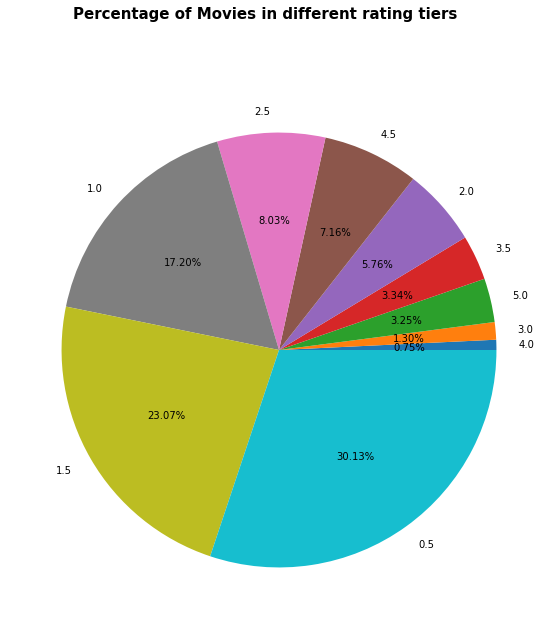

In [84]:
# Percentage of movies in different rating tiers

figure = plt.figure(figsize=(15,10))
plt.pie(df_combined["rating"].value_counts().sort_values(), labels=df_combined["rating"].value_counts().index, autopct='%1.2f%%')
figure.suptitle('Percentage of Movies in different rating tiers', fontsize=15, fontweight='bold')
plt.show()

### Plot the percentage of movies based on production

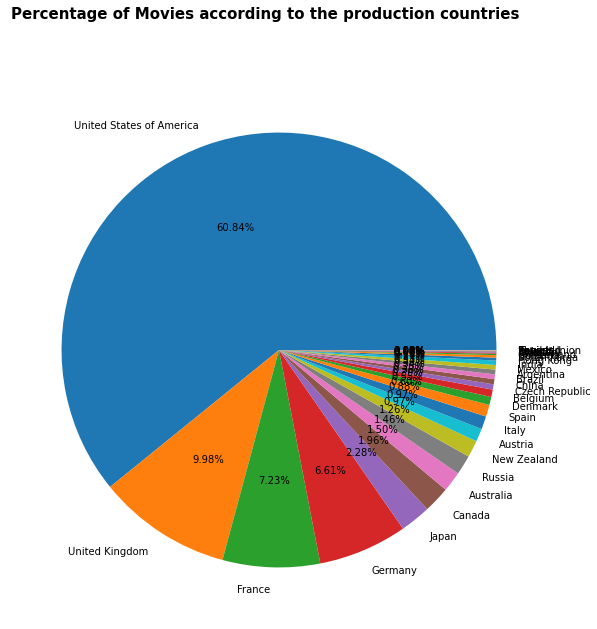

In [85]:
figure = plt.figure(figsize=(15,10))
plt.pie(df_combined["production_countries"].value_counts(), labels=df_combined["production_countries"].value_counts().index, autopct='%1.2f%%')
figure.suptitle('Percentage of Movies according to the production countries', fontsize=15, fontweight='bold')
plt.show()